In [ ]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
import pandas as pd
from autobound.Query import Query
import numpy as np



def ecd(prob_df, disparity_metric, ecd_param,dag_type="UC",constraint = "CF"):
    if "Z" in prob_df.columns:
        prob_df["Y"] = prob_df["Z"]
        prob_df = prob_df.drop("Z",axis=1)
    
    dag = DAG()

    if dag_type == "UC":
        dag.from_structure("A->Y,A->P,A->T,T->Y,U->Y,U->P,V->T,V->P,W->T,W->Y",unob="U,V,W" )

    if dag_type == "C":
        dag.from_structure("A->Y,A->P,A->T,T->Y,U->Y,U->P,V->T,V->P",unob="U,V" )


    problem = causalProblem(dag)

    numerator, denominator = get_metric_expressions(problem, disparity_metric, outcome_variable="Y(T=1)")
    problem.load_data(prob_df)
    problem.add_prob_constraints()
    problem.set_estimand(numerator,div=denominator)

    if constraint == "CF":
        problem.add_constraint(problem.query("Y(T=1)=1&Y(T=0)=0")+problem.query("Y(T=1)=0&Y(T=0)=1")- Query(ecd_param),symbol="<=")

    if constraint == "MT_CF":
        problem.add_constraint(problem.query("Y(T=1)=0&Y(T=0)=1"),symbol="==")
        problem.add_constraint(problem.query("Y(T=1)=1&Y(T=0)=0")- Query(ecd_param),symbol="<=")
    
    
    program = problem.write_program()

    
    result = program.run_pyomo('ipopt',verbose=False)

    return result


metric = "FPR"

predictor = train_fairness_classifiers(X_train, y_train, A_train, disparity_metric=metric)[0]
c = 0.2
T = (np.random.random(len(A)) > 1/2- c*A).astype(int)
T_test = T[perm][-prop:]
df = pd.DataFrame({
    "A": A_test, "Y": y_test, "P": predictor.predict(X_test), "T": T_test
})
prob_df_T = joint_distribution(df, ["A", "Y", "P", "T"])
prob_df_no_T = joint_distribution(df, ["A", "Y", "P"])

In [1]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
from src.autobounds_tools import chi_square_terms,get_numerator_denominator
import pandas as pd
from autobound.Query import Query
import numpy as np
import itertools
import torch
from io import StringIO
import pyomo.environ as pyo
import io 
from copy import deepcopy
from autobound.Program import pyomo_symb,mult_params_pyomo,parse_bounds,solve1
import matplotlib.pyplot as plot
from sklearn.linear_model import LogisticRegression
from src.utils import return_prob_df, train_fairness_classifiers,return_prob_df_unselected,calc_disparity_metric

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import bernoulli
sns.set_theme()
sns.set_style("whitegrid")

In [3]:
def return_prob_df_ECP(predictor,X_test,y_test,A_test,T_vec):
    df = {"A": A_test, "Z": y_test, "P": predictor.predict(X_test), "T": T_vec}
    df = pd.DataFrame(df)
    data_dict = {"A": [], "Z": [], "P": [], "T": [], "prob": []}
    for i,j,k,m in itertools.product(range(2),range(2),range(2),range(2)):
        p = np.zeros([2,2,2,2])
        p[i, j, k, m] = ((df["A"] == i) & (df["Z"] == j) & (df["P"] == k) & (df["T"] == m)).mean()
        data_dict["A"].append(i)
        data_dict["Z"].append(j)
        data_dict["P"].append(k)
        data_dict["T"].append(m)
        data_dict["prob"].append((p[i, j, k, m].item()))
    prob_df = pd.DataFrame(data_dict)
    return prob_df


In [4]:
ds = np.load("data/adult.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]

perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [5]:
disparity_metric = "EO_max"

predictor = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric=disparity_metric)[0]

prob_df_no_T = return_prob_df(predictor,X_test,y_test,A_test)

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [6]:
def ecd(prob_df,ecd_param,dag_type="UC",constraint = "CF",optimiser="ipopt"):
    if "Z" in prob_df.columns:
        prob_df["Y"] = prob_df["Z"]
        prob_df = prob_df.drop("Z",axis=1)
    
    dag = DAG()

    if dag_type == "UC":
        dag.from_structure("A->Y,A->P,A->T,T->Y,U->Y,U->P,V->T,V->P,W->T,W->Y",unob="U,V,W" )

    if dag_type == "C":
        dag.from_structure("A->Y,A->P,A->T,T->Y,U->Y,U->P,V->T,V->P",unob="U,V" )


    problem = causalProblem(dag)

    numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff",causal=True)
    problem.load_data(StringIO(prob_df.to_csv(index=False)))
    problem.add_prob_constraints()
    problem.set_estimand(numerator,div=denominator)

    if constraint == "CF":
        problem.add_constraint(problem.query("Y(T=1)=1&Y(T=0)=0")+problem.query("Y(T=1)=0&Y(T=0)=1")- Query(ecd_param),symbol="<=")

    if constraint == "ATE":
        problem.add_constraint(problem.query("Y(T=1)=1")-problem.query("Y(T=0)=1")- Query(ecd_param),symbol="<=")
        problem.add_constraint(problem.query("Y(T=1)=1")-problem.query("Y(T=0)=1")- Query(ecd_param),symbol="<=")
        
    if constraint == "ATE_EQ":
        P_A1 = (prob_df["prob"][prob_df["A"]==1]).sum()
        P_A0 = (prob_df["prob"][prob_df["A"]==0]).sum()
        P_P1 = (prob_df["prob"][prob_df["P"]==1]).sum()
        P_P0 = (prob_df["prob"][prob_df["P"]==0]).sum()
        problem.add_constraint(problem.query("Y(T=1)=1&A=1&P=1")-problem.query("Y(T=0)=1&A=1&P=1")- Query(ecd_param*P_A1*P_P1),symbol="<=")
        problem.add_constraint(problem.query("Y(T=1)=1&A=1&P=0")-problem.query("Y(T=0)=1&A=1&P=0")- Query(ecd_param*P_A1*P_P0),symbol="<=")
        problem.add_constraint(problem.query("Y(T=1)=1&A=0&P=0")-problem.query("Y(T=0)=1&A=0&P=0")- Query(ecd_param*P_A0*P_P0),symbol="<=")
        problem.add_constraint(problem.query("Y(T=1)=1&A=0&P=1")-problem.query("Y(T=0)=1&A=0&P=1")- Query(ecd_param*P_A0*P_P1),symbol="<=")

    if constraint == "MT_CF":
        problem.add_constraint(problem.query("Y(T=1)=0&Y(T=0)=1"),symbol="==")
        problem.add_constraint(problem.query("Y(T=1)=1&Y(T=0)=0")- Query(ecd_param),symbol="<=")
    
    if constraint == "MT_ATE":
        problem.add_constraint(problem.query("Y(T=1)=0&Y(T=0)=1"),symbol="==")
        problem.add_constraint(problem.query("Y(T=1)=1")-problem.query("Y(T=0)=1")- Query(ecd_param),symbol="<=")
    
    program = problem.write_program()

    if optimiser=="ipopt":
        result = program.run_pyomo('ipopt',verbose=False)
    if optimiser=="couenne":
        M = pyo.ConcreteModel()
        solver = pyo.SolverFactory('couenne')
        for p in program.parameters:
            if p != 'objvar':
                setattr(M, p, pyo.Var(bounds = (0,1)))
            else:
                setattr(M, p, pyo.Var())
        # Next loop is not elegant, needs refactoring
        for i, c in enumerate(program.constraints):
            setattr(M, 'c' + str(i), 
                    pyo.Constraint(expr = 
                        pyomo_symb[c[-1][0]](sum([ mult_params_pyomo(program.parameters, k, M ) for k in c[:-1] ]), 0)
                    )
            )
        program.M_upper = deepcopy(M)
        program.M_lower = deepcopy(M)
        program.M_upper.obj = pyo.Objective(expr = program.M_upper.objvar, sense = pyo.maximize)
        program.M_lower.obj = pyo.Objective(expr = program.M_lower.objvar, sense = pyo.minimize)
        solve1(solver,program.M_lower,'lower',True)
        result = None
    return result

In [7]:
ecd_param = 0.05
c = 0.2
T = (np.random.random(len(A)) > 1/2 - c * A).astype(int)
T_test = T[perm][-prop:]
prob_df = return_prob_df_ECP(predictor,X_test,y_test,A_test,T_test)

In [8]:
calc_disparity_metric(y_test,predictor.predict(X_test),A_test,disparity_metric)

0.056855715145731955

In [9]:
ecd(prob_df_no_T, ecd_param, constraint="CF")

UnboundLocalError: local variable 'target_variable' referenced before assignment

In [ ]:
ecd(prob_df_no_T,ecd_param,constraint="MT_CF")

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

(0.0846114887620387, 0.24844610030626185)

In [ ]:
ecd(prob_df,ecd_param,constraint="ATE_EQ")

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

(-0.07705042363607732, 0.08623669574352366)

In [ ]:
ecd(prob_df,ecd_param,constraint="MT_CF")

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

(-0.016166262419910492, 0.026430247981549145)

In [ ]:
ecd(prob_df,ecd_param,dag_type="C")

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

(-0.03370866402060572, 0.06036177549817118)

In [ ]:
ecd(prob_df_no_T,ecd_param,constraint="CF")

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

(-0.07750653179825398, 0.1169941388130937)

In [ ]:
ecd(prob_df_no_T,ecd_param,constraint="MT_CF")

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

(-0.04460192518812538, 0.04781994098398205)

In [ ]:
metrics = ["FPR","FNR","PPP","NPP"]

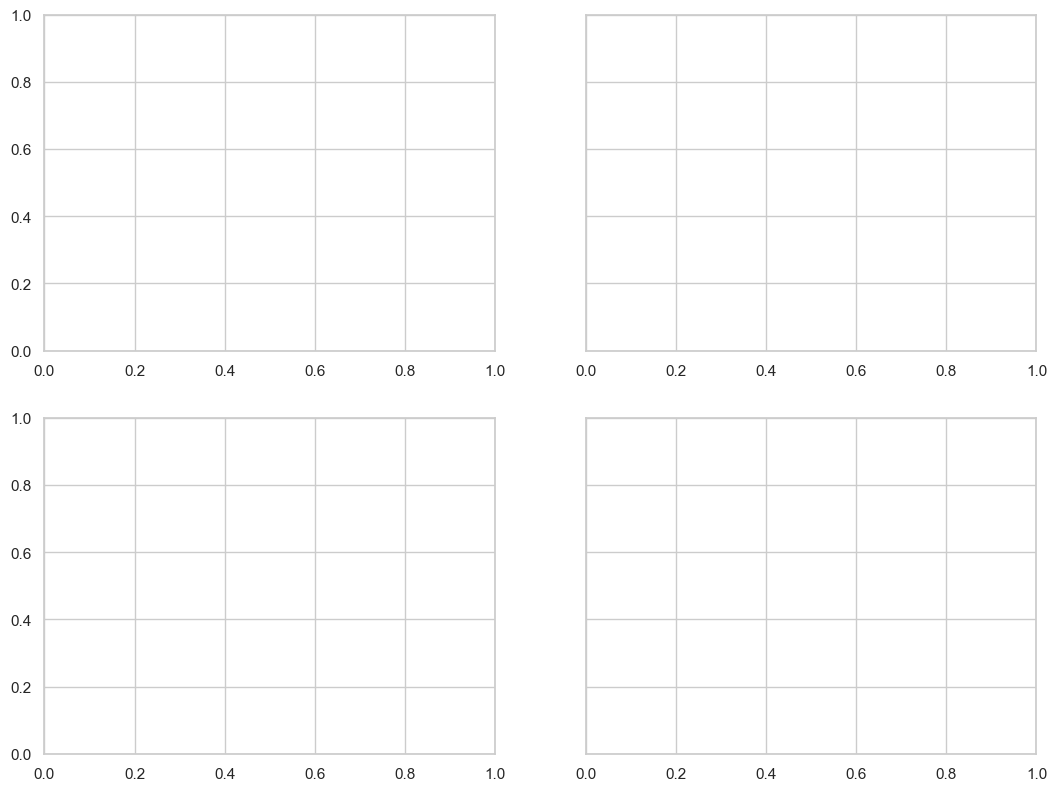

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2,sharey=True,figsize= (25.6/2,9.6 ))
ax = ax.reshape(4,1)

In [ ]:
ax[1]

array([<Axes: >], dtype=object)

/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

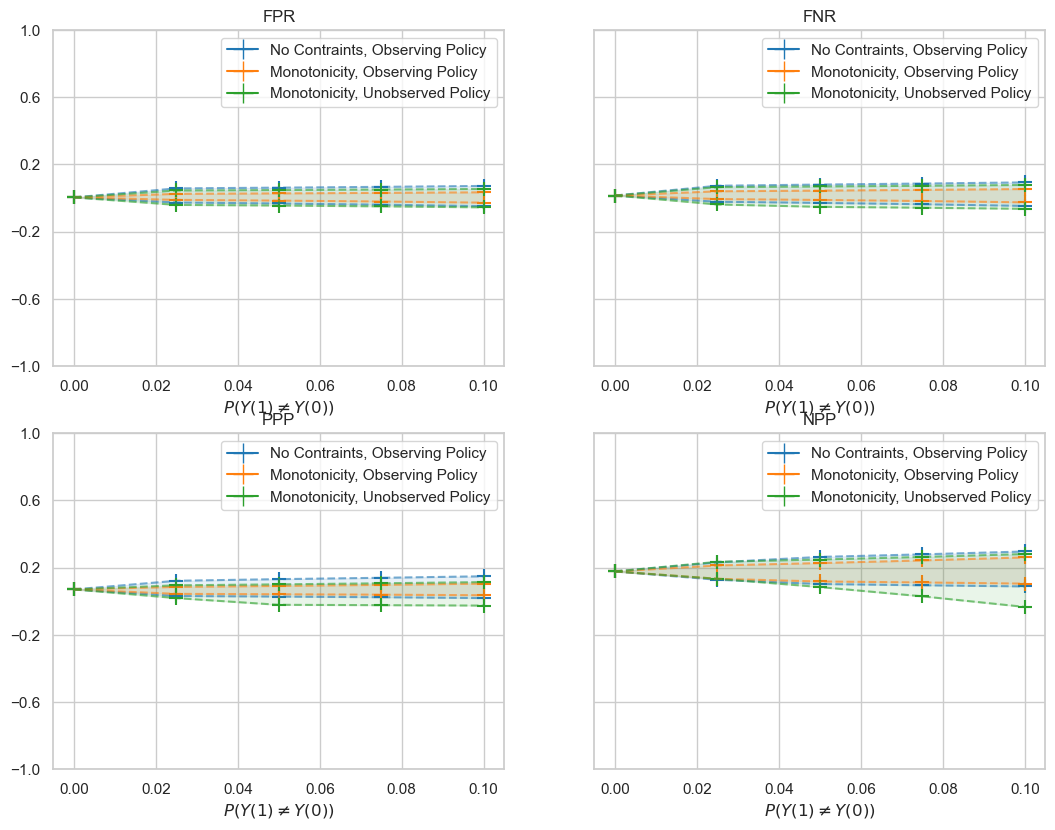

In [ ]:
colours = sns.color_palette("tab10", 4)


fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize= (25.6/2,9.6))
ax = ax.reshape(4)

constraints = [("CF", True),("MT_CF", True),("MT_CF", False)]
labels = ["No Contraints, Observing Policy", "Monotonicity, Observing Policy", "Monotonicity, Unobserved Policy"]
range_ab = np.linspace(0,0.1,5)
lines = []

for j, metric in enumerate(metrics):
    predictor = train_fairness_classifiers(X_train, y_train, A_train, disparity_metric=metric)[0]
    prob_df_no_T = return_prob_df(predictor,X_test,y_test,A_test)  
    c = 0.2
    T = (np.random.random(len(A)) > 1/2- c*A).astype(int)
    T_test = T[perm][-prop:]
    prob_df = return_prob_df_ECP(predictor,X_test,y_test,A_test,T_test)
    for i, constraint in enumerate(constraints):
        lower_results = []
        upper_results = []

        for val in range_ab:
            if constraint[1]:
                sens_results = ecd(prob_df, val, constraint=constraint[0])
                lower_results.append(sens_results[0])
                upper_results.append(sens_results[1])
            
            else: 
                sens_results = ecd(prob_df_no_T, val, constraint=constraint[0])
                lower_results.append(sens_results[0])
                upper_results.append(sens_results[1])


        ax[j].fill_between(range_ab, lower_results, upper_results, alpha=.1,color = colours[i])
        ax[j].plot(range_ab, upper_results, ls='--', alpha=.6,color=colours[i])
        ax[j].plot(range_ab, lower_results, ls='--', alpha=.6,color=colours[i])

        ax[j].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
        ax[j].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])

    legend_elements = [Line2D([0], [0], marker='+', color=colours[0], label='Scatter',
                            markerfacecolor='b', markersize=15),
                        Line2D([0], [0], marker='+', color=colours[1], label='Scatter',
                            markerfacecolor='b', markersize=15),
                        Line2D([0], [0], marker='+', color=colours[2], label='Scatter',
                            markerfacecolor='b', markersize=15)]

    ax[j].legend(handles = legend_elements,labels = labels)
    ax[j].set_yticks(np.arange(-1, 1.2, 0.4))
    ax[j].set_xlabel(r"$P(Y(1) \neq Y(0))$")
    ax[j].set_title(metric)

In [ ]:
fig.subplots_adjust(hspace=0.3)

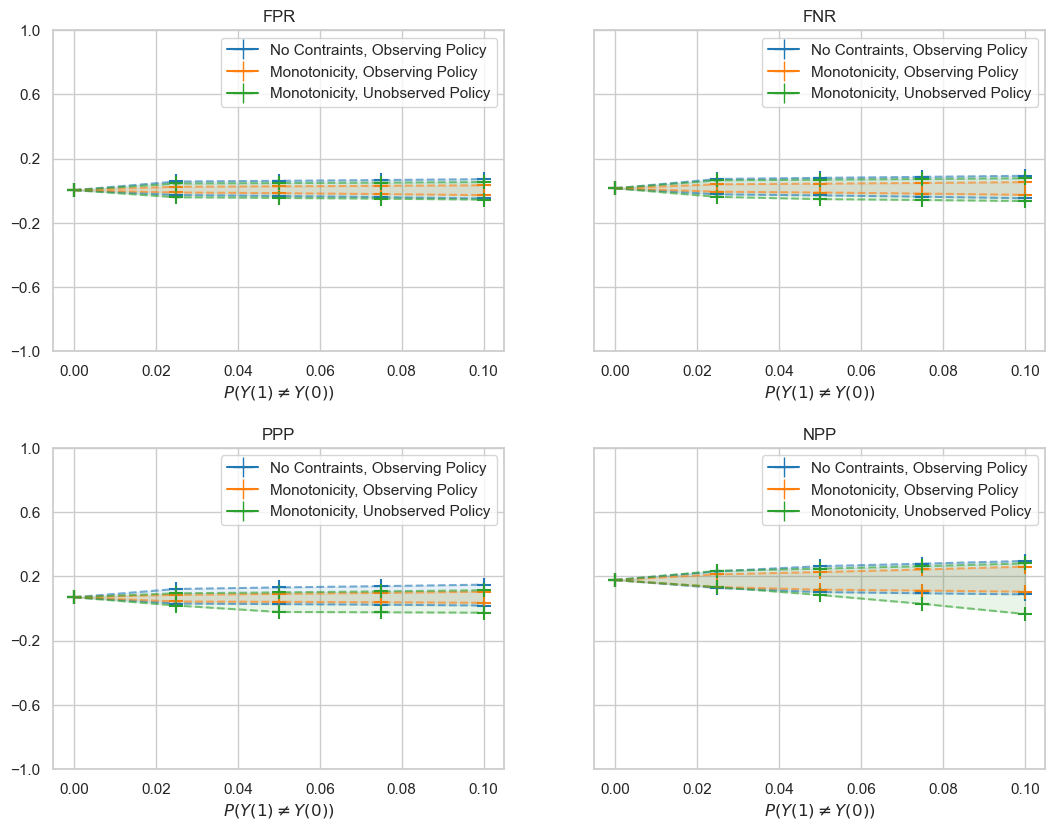

In [ ]:
fig

In [ ]:
ax

array([<Axes: title={'center': 'FPR'}, xlabel='$P(Y(1) \\neq Y(0))$'>,
       <Axes: title={'center': 'FNR'}, xlabel='$P(Y(1) \\neq Y(0))$'>,
       <Axes: title={'center': 'PPP'}, xlabel='$P(Y(1) \\neq Y(0))$'>,
       <Axes: title={'center': 'NPP'}, xlabel='$P(Y(1) \\neq Y(0))$'>],
      dtype=object)

In [ ]:
ax.set_xlabel(r"$P(Y(1) \neq Y(0))$")
ax.set_ylabel("Metric value")

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

In [ ]:
ax.set_title("Counterfactual False Positive Rate Parity Under ECP bias")

Text(0.5, 1.0, 'Counterfactual False Positive Rate Parity Under ECP bias')

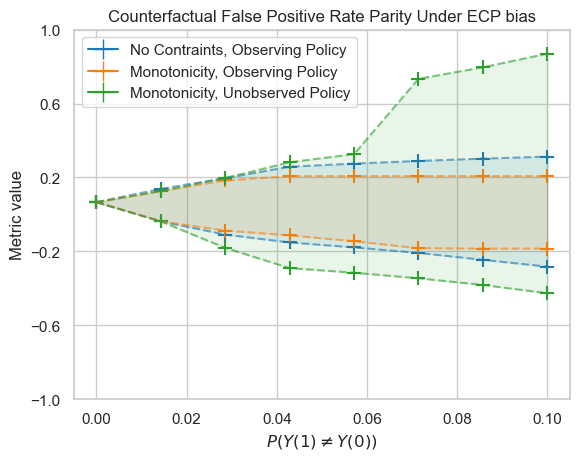

In [ ]:
fig

In [ ]:
if "Y" in prob_df_no_T.columns:
    prob_df_no_T["Z"] = prob_df_no_T["Y"]
    prob_df_no_T = prob_df_no_T.drop("Y",axis=1)

dag = DAG()
dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
problem = causalProblem(dag)
problem.load_data(StringIO(prob_df_no_T.to_csv(index=False)))
problem.add_prob_constraints()
numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")
problem.set_estimand(numerator,div=denominator)
problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1")- Query(ecd_param),symbol="<=")
program = problem.write_program()
result = program.run_pyomo('ipopt')
result

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      961
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:    14560

Total number of variables............................:      257
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      257
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of in

(0.0665760053166159, 0.06658395367696268, True, True)